Something Something

# Import libraries

In [2]:
from matplotlib import pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_validate,
    StratifiedKFold,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from scipy.stats import uniform, randint
from sklearn.dummy import DummyClassifier
from typing import List
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Functions


In [2]:
def print_conf_matrix(pipe: Pipeline, X_train, X_test, y_train, y_test):
    """Display the confusion matrix for the given model

    Argument:
    pipe: Pipeline of the model
    X_train, X_test, y_train, y_test: Train and test data
    """
    # Train and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Display the classification report
    print(classification_report(y_test, y_pred))

    # Display the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"{pipe.steps[1][0]}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc_curves(pipelines: List[Pipeline], X_train, y_train, X_test, y_test):
    """Plots ROC curves for multiple pipelines.

    Args:
    pipelines: A list of Pipeline objects.
    X_train, X_test, y_train, y_test: Train and test data
    """

    # Make a bigger figure
    plt.figure(figsize=(10, 6))

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{pipeline.steps[3][0]} (AUC = {roc_auc:.3f})")

    plt.plot(
        [0, 1], [0, 1], linestyle="--", color="gray", linewidth=2
    )  # Create the threshold line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves of all models")
    plt.legend(loc="lower right")
    plt.show()


def get_params_for_model(params_dict):
    """Returns a list of dictionaries with the parameters for the model.

    Argument:
    params_dict: A dictionary with the parameters for the model.
    """
    dicts_list = []
    for params in params_dict:
        dict = {key.split("__")[1]: value for key, value in params.items()}
        dicts_list.append(dict)
    return dicts_list

# Import data


In [3]:
df_master = pd.read_csv("../data/Customer-Churn-Records.csv")
df = df_master.copy()

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Exploratory data analysis


In [5]:
# Check if duplicates exist
df.duplicated().sum()

0

## Analyze columns types and nulls


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

> Comment:

- **RowNumber** column is basically index column,
- There is no null values in this dataset,
- Columns from the first glance seem to be in the correct type.


## Analyze numeric columns statistics


In [4]:
# Drop ids and target
num_col_df = df.drop(["RowNumber", "CustomerId", "Exited"], axis=1)
num_col_df.describe().round(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Point Earned
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204,3.014,606.515
std,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403,1.406,225.925
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000,1.000,119.000
25%,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000,2.000,410.000
50%,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000,3.000,605.000
75%,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.248,0.000,4.000,801.000
max,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000,5.000,1000.000


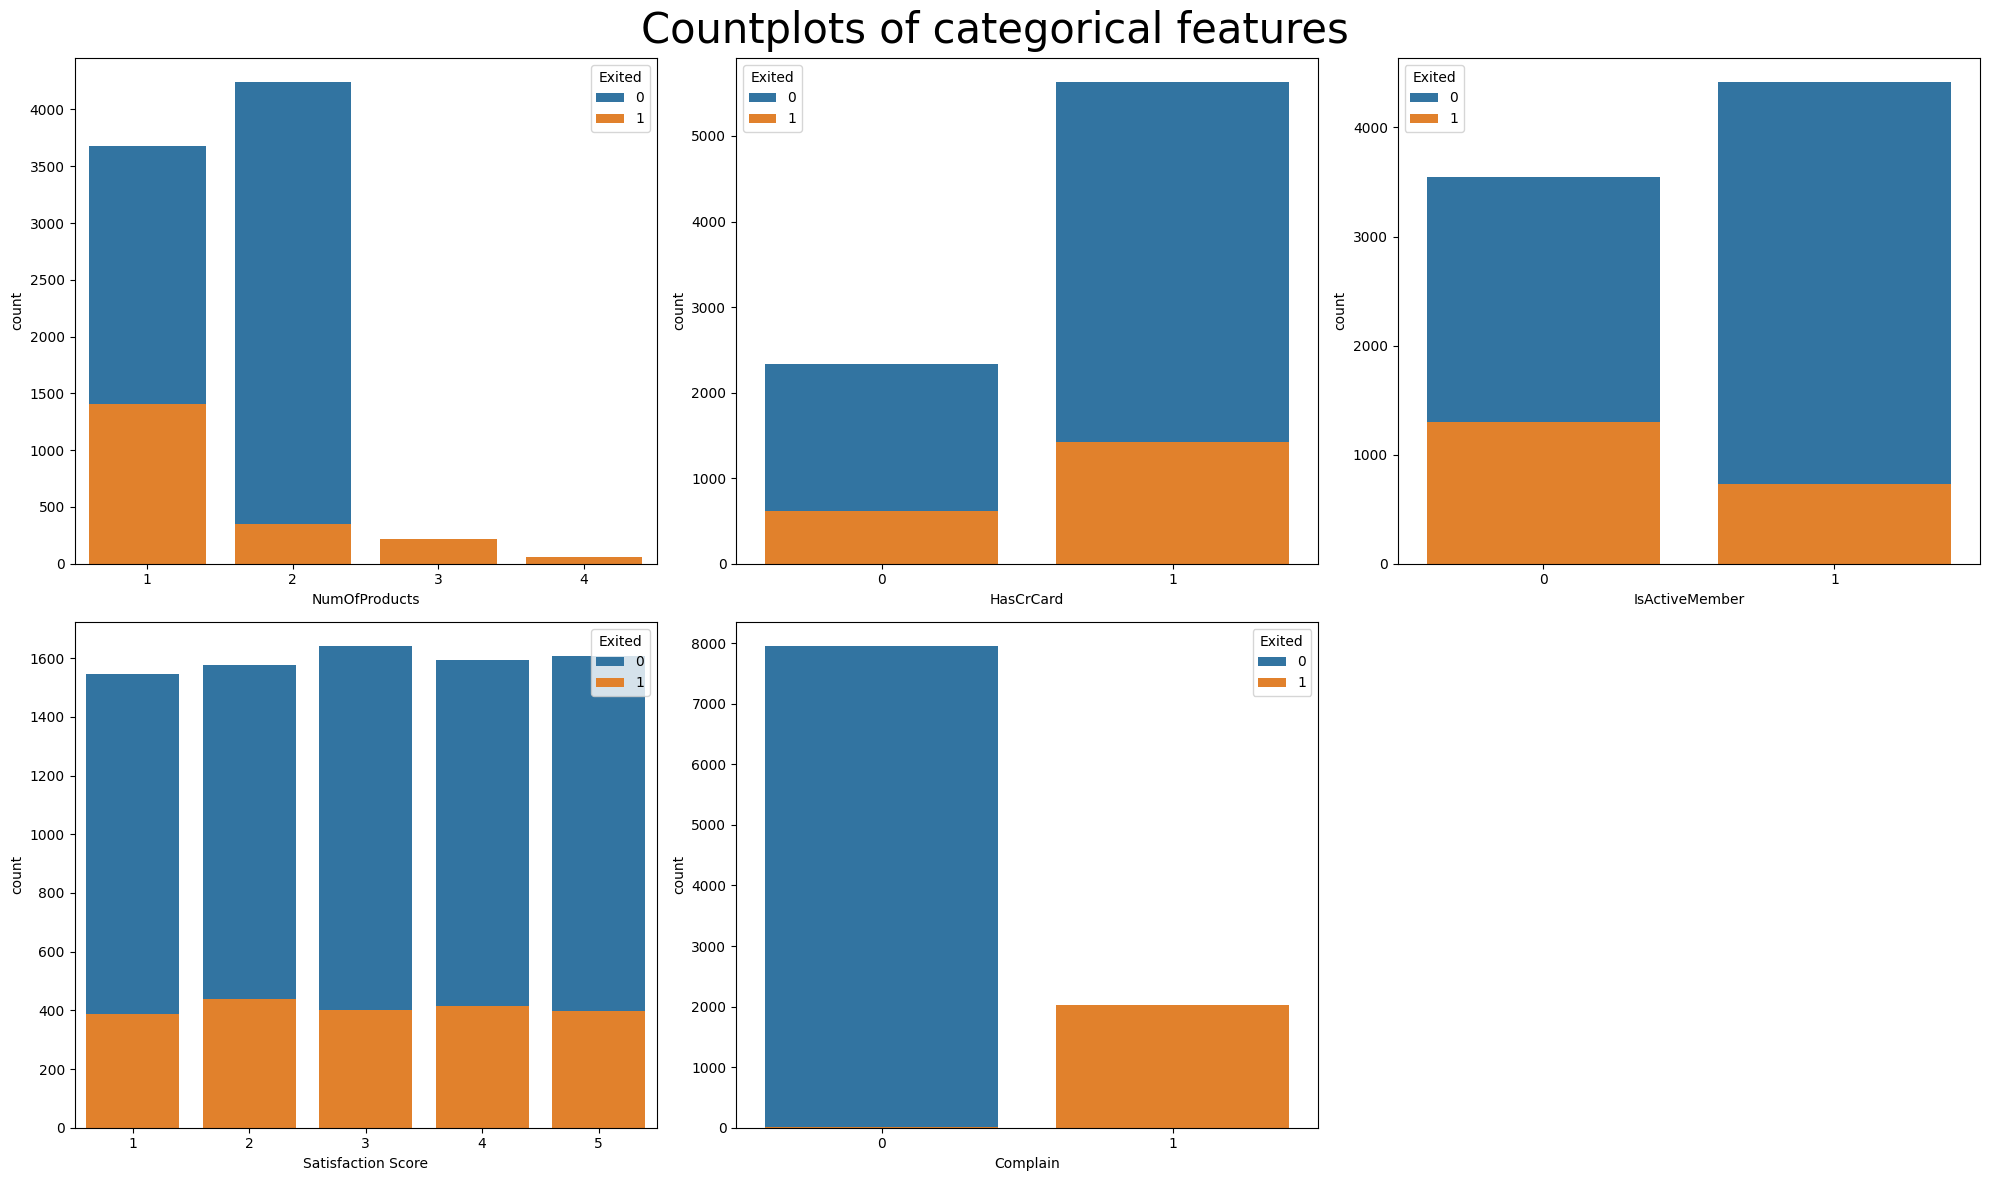

In [12]:
# Create grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes[1, 2].remove()  # Remove the empty subplot

sns.countplot(data=df, x="NumOfProducts", hue="Exited", dodge=False, ax=axes[0, 0])
sns.countplot(data=df, x="HasCrCard", hue="Exited", dodge=False, ax=axes[0, 1])
sns.countplot(data=df, x="IsActiveMember", hue="Exited", dodge=False, ax=axes[0, 2])
sns.countplot(data=df, x="Satisfaction Score", hue="Exited", dodge=False, ax=axes[1, 0])
sns.countplot(data=df, x="Complain", hue="Exited", dodge=False, ax=axes[1, 1])

plt.suptitle("Countplots of categorical features", fontsize=30)
plt.tight_layout()
plt.show()

> Comment:

- Excluding **RowNumber** and **CustomerId** columns, other columns seem to not have abnormal values.
- **NumOfProducts** and **Statisfaction Score** columns are categorical in numeric.
- **HasCrCard**, **IsActiveMember** and **Complain** columns are binary in numeric.


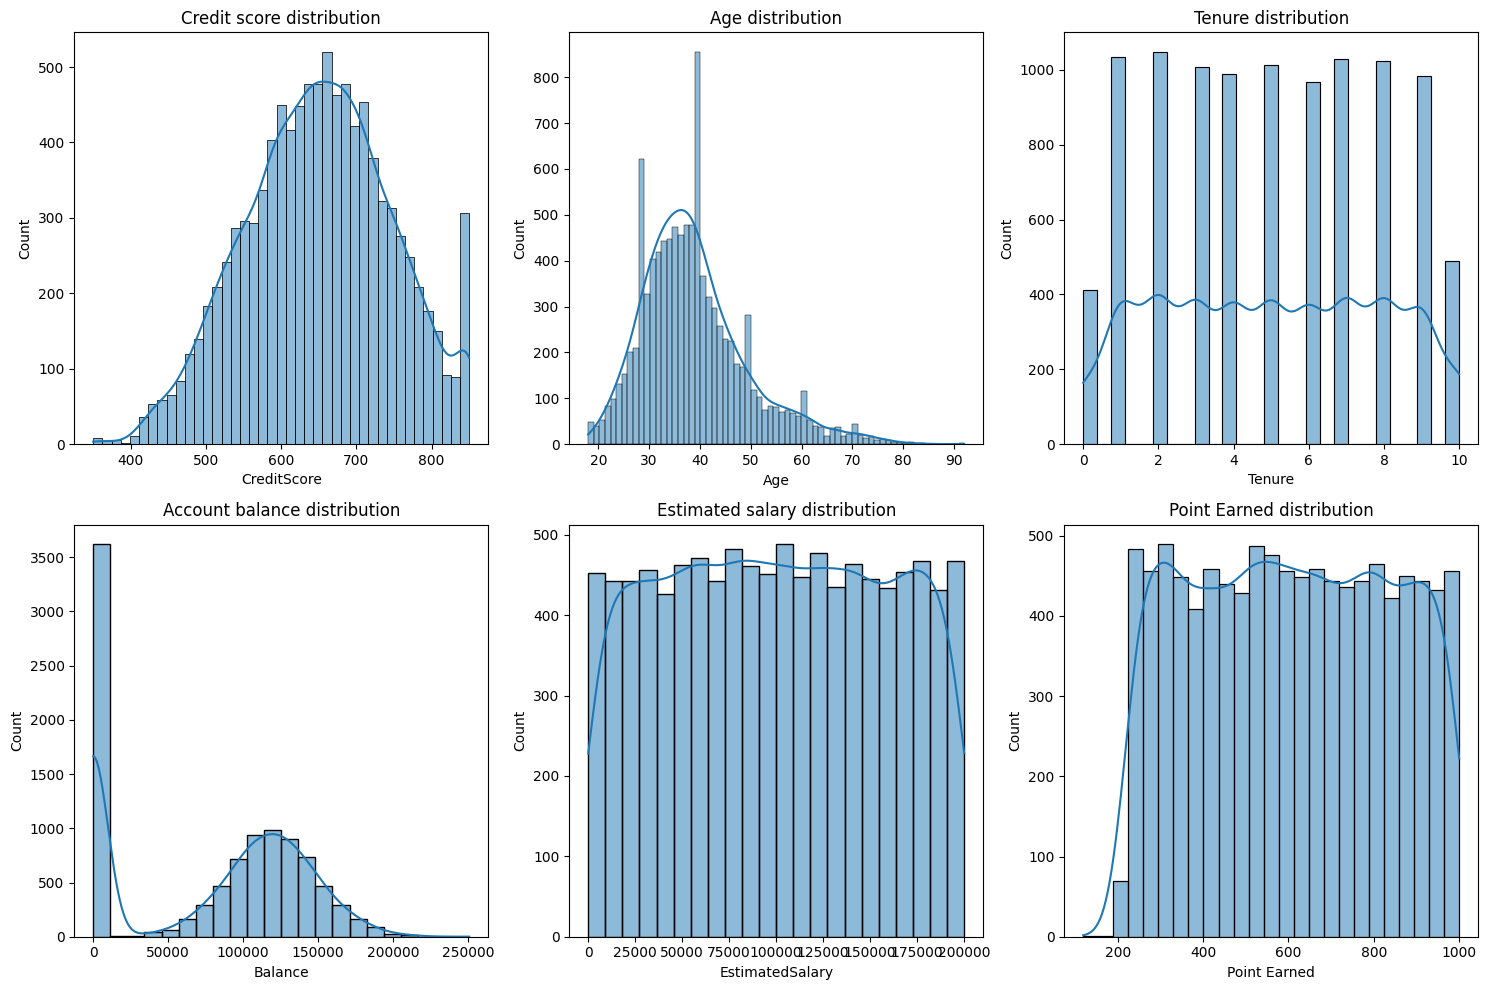

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data=df, x="CreditScore", kde=True)
plt.title("Credit score distribution")

plt.subplot(2, 3, 2)
sns.histplot(data=df, x="Age", kde=True)
plt.title("Age distribution")

plt.subplot(2, 3, 3)
sns.histplot(data=df, x="Tenure", kde=True)
plt.title("Tenure distribution")

plt.subplot(2, 3, 4)
sns.histplot(data=df, x="Balance", kde=True)
plt.title("Account balance distribution")

plt.subplot(2, 3, 5)
sns.histplot(data=df, x="EstimatedSalary", kde=True)
plt.title("Estimated salary distribution")

plt.subplot(2, 3, 6)
sns.histplot(data=df, x="Point Earned", kde=True)
plt.title("Point Earned distribution")

plt.tight_layout()
plt.show()

In [15]:
# Check the skewness of the numerical columns
num_col_to_check = ["CreditScore", "Age", "Balance"]

for column_name in num_col_to_check:
    skewness = df[column_name].skew()
    print(f"The skewness coefficient of {column_name} is: {skewness}")

The skewness coefficient of CreditScore is: -0.07160660820092675
The skewness coefficient of Age is: 1.0113202630234552
The skewness coefficient of Balance is: -0.14110871094154384


> Comment: Credit Score is slightly normal distribution, Age is skewed and needed to be transformed. In model training phase, features scaling need to be applied if we use models that are sensitive to the scaling.


## Analyze "string" columns


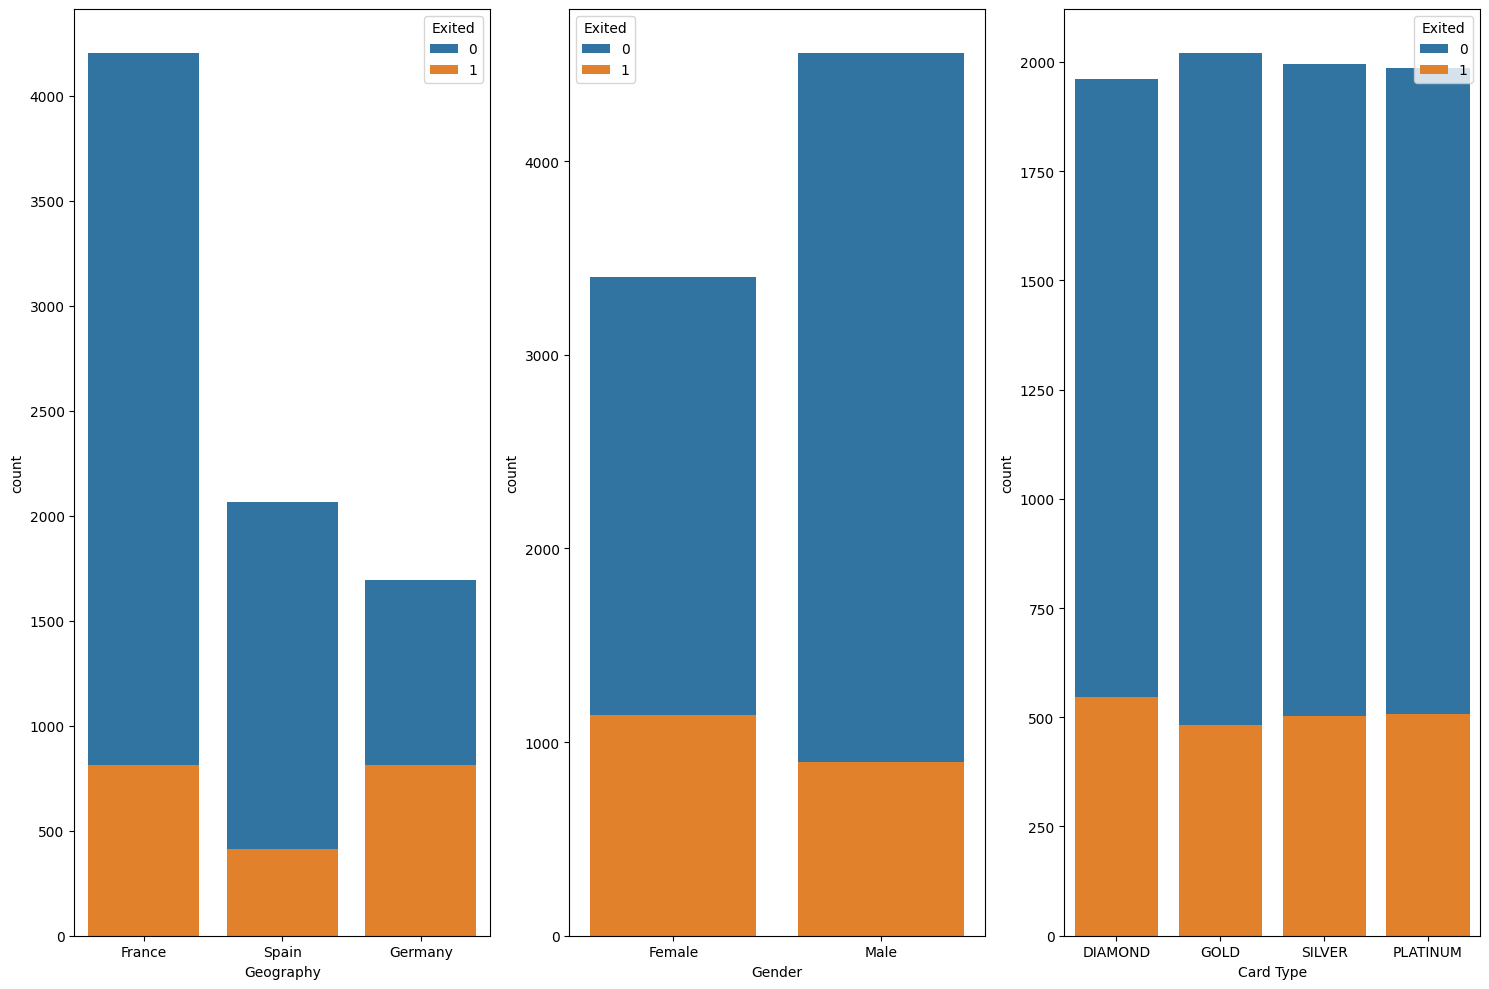

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x="Geography", hue="Exited", dodge=False)

plt.subplot(1, 3, 2)
sns.countplot(data=df, x="Gender", hue="Exited", dodge=False)

plt.subplot(1, 3, 3)
sns.countplot(data=df, x="Card Type", hue="Exited", dodge=False)

plt.tight_layout()
plt.show()

> Comment:

- There are only three countries, which may introduce bias in the model training.
- Only two genders found in the dataset, which is fine.
- 4 types of card which are in normal state.


## Analyze target column


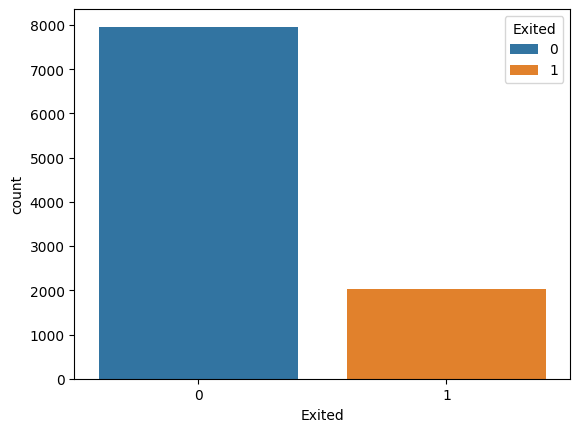

In [19]:
sns.countplot(data=df, x="Exited", hue="Exited")
plt.show()

> Comment: There is an imbalance in the target, which may cause bias in the model training phase.


## Analyze the relationship between columns and the target.

Since we are doing a churn prediction application and the target is the **Exited** column, we want to know whether there is a linearly separable relationship.


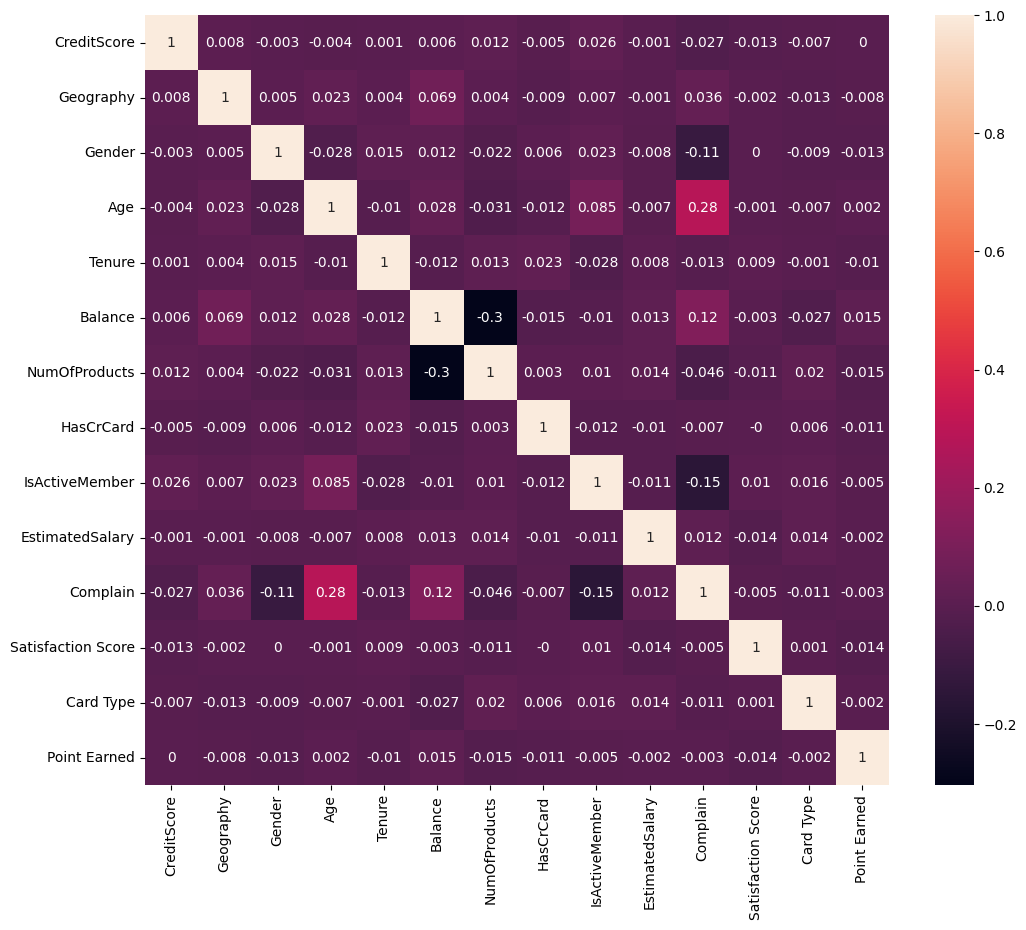

In [20]:
no_target_corr = df.copy().drop(
    ["RowNumber", "CustomerId", "Surname", "Exited"], axis=1
)

no_target_corr.Gender = no_target_corr.Gender.astype("category").cat.codes
no_target_corr.Geography = no_target_corr.Geography.astype("category").cat.codes
no_target_corr["Card Type"] = no_target_corr["Card Type"].astype("category").cat.codes

plt.figure(figsize=(12, 10))
sns.heatmap(no_target_corr.corr().round(3), annot=True)
plt.show()

In [21]:
for_corr_df = df.copy().drop(["RowNumber", "CustomerId", "Surname"], axis=1)

for_corr_df.Gender = for_corr_df.Gender.astype("category").cat.codes
for_corr_df.Geography = for_corr_df.Geography.astype("category").cat.codes
for_corr_df["Card Type"] = for_corr_df["Card Type"].astype("category").cat.codes

for_corr_df.corr().abs()["Exited"].sort_values(ascending=False)

Exited                1.000000
Complain              0.995693
Age                   0.285296
IsActiveMember        0.156356
Balance               0.118577
Gender                0.106267
NumOfProducts         0.047611
Geography             0.035712
CreditScore           0.026771
Tenure                0.013656
EstimatedSalary       0.012490
Card Type             0.010861
HasCrCard             0.006976
Satisfaction Score    0.005849
Point Earned          0.004628
Name: Exited, dtype: float64

> Comment:

- There is no significant correlation between columns excluding the target.
- Our target most correlated with **Complain** column


# Model training


## Isolate features and target


In [22]:
train = pd.read_csv("../data/customer_churn_records.csv")
train.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,CardType,PointEarned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [23]:
features_org = train.drop(
    ["RowNumber", "CustomerId", "Surname", "Complain", "Exited"], axis=1
)
features_names = features_org.columns
target = train.Exited

print(f"{target.unique()}\n")
features_org.head()

[1 0]



,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SatisfactionScore,CardType,PointEarned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425


## The original features set


### Split dataset


In [24]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    features_org, target, test_size=0.2, shuffle=True, stratify=target, random_state=42
)

print(X_train_1.shape)
print(X_test_1.shape)

(8000, 13)
(2000, 13)


### Feature processing


#### Prepare Transfomer objets


In [25]:
binary_cols = ["Gender"]
ordinal_cols = ["CardType"]
ohe_col = ["Geography"]
numeric_cols = [
    "CreditScore",
    "Age",
    "Tenure",
    "Balance",
    "EstimatedSalary",
    "PointEarned",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("binary", OrdinalEncoder(), binary_cols),
        (
            "ordinal",
            OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]]),
            ordinal_cols,
        ),
        ("ohe", OneHotEncoder(), ohe_col),
        ("scaler", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)


X_train_1_processed = preprocessor.fit_transform(X_train_1)
X_test_1_processed = preprocessor.transform(X_test_1)

print(f"Before: {X_train_1.shape}")
print(f"After: {X_train_1_processed.shape}")

Before: (8000, 13)
After: (8000, 15)


### Baseline models


In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_1, y_train_1)
dummy_pred = dummy_clf.predict(X_test_1)

print(f"Dummy classifier accuracy: {accuracy_score(y_test_1, dummy_pred)}")

Dummy classifier accuracy: 0.796


> Comment: Created a dummy model as a baseline to compare the other algorithms. The baseline for this classification task is to predict the mode of the target variable. In this case, since the churn vs non-churn distribution is 1 to 4, if we predict randomly then 80% of the time a customer would be classified as non-churner.


### Comparison models


In [27]:
logistic_reg_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("log_classifier", LogisticRegression(random_state=42)),
    ]
)

random_forest_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rf_classifier", RandomForestClassifier(random_state=42)),
    ]
)

gradient_boosting_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("boost_classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

xgb_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("xgb_classifier", XGBClassifier())]
)

#### Without resampling


In [28]:
scoring = ["accuracy", "precision", "recall", "roc_auc", "f1"]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
logistic_cv = cross_validate(
    logistic_reg_pipe, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
rf_cv = cross_validate(
    random_forest_pipe, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
grb_cv = cross_validate(
    gradient_boosting_pipe, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
xgb_cv = cross_validate(xgb_pipe, X_train_1, y_train_1, cv=kfold, scoring=scoring)

##### Model evaluation


In [30]:
names = ["Logistic Regression", "Random Forest", "Gradient Boosting", "XGBoost"]
cv_scores = [logistic_cv, rf_cv, grb_cv, xgb_cv]

result_df = pd.DataFrame(
    {
        "Model name": names,
        "Mean Accuracy": [np.mean(scores["test_accuracy"]) for scores in cv_scores],
        "Mean Precision": [np.mean(scores["test_precision"]) for scores in cv_scores],
        "Mean Recall": [np.mean(scores["test_recall"]) for scores in cv_scores],
        "Mean ROC AUC": [np.mean(scores["test_roc_auc"]) for scores in cv_scores],
        "Mean F1 Score": [np.mean(scores["test_f1"]) for scores in cv_scores],
    }
)

result_df.set_index("Model name", inplace=True)
result_df

,Mean Accuracy,Mean Precision,Mean Recall,Mean ROC AUC,Mean F1 Score
Model name,,,,,
Logistic Regression,0.809125,0.592592,0.206748,0.763068,0.306050
Random Forest,0.861625,0.792103,0.434969,0.850020,0.561518
Gradient Boosting,0.861500,0.771209,0.455215,0.861999,0.572341
XGBoost,0.850375,0.690477,0.484049,0.837442,0.568673


#### With resampling


##### Simple oversampling


In [31]:
smote = SMOTE(random_state=42)

smote_log = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("log_classifier", LogisticRegression(random_state=42)),
    ]
)

smote_rf = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("rf_classifier", RandomForestClassifier(random_state=42)),
    ]
)

smote_grb = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("boost_classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

smote_xgb = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", smote),
        ("xgb_classifier", XGBClassifier()),
    ]
)

In [32]:
resampled_logistic_cv = cross_validate(
    smote_log, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
resampled_rf_cv = cross_validate(
    smote_rf, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
resampled_grb_cv = cross_validate(
    smote_grb, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
resampled_xgb_cv = cross_validate(
    smote_xgb, X_train_1, y_train_1, cv=kfold, scoring=scoring
)

###### Model evaluation


In [33]:
resampled_cv_scores = [
    resampled_logistic_cv,
    resampled_rf_cv,
    resampled_grb_cv,
    resampled_xgb_cv,
]

result_df_2 = pd.DataFrame(
    {
        "Model name": names,
        "Accuracy": [
            np.mean(scores["test_accuracy"]) for scores in resampled_cv_scores
        ],
        "Precision": [
            np.mean(scores["test_precision"]) for scores in resampled_cv_scores
        ],
        "Recall": [np.mean(scores["test_recall"]) for scores in resampled_cv_scores],
        "ROC AUC": [np.mean(scores["test_roc_auc"]) for scores in resampled_cv_scores],
        "F1 Score": [np.mean(scores["test_f1"]) for scores in resampled_cv_scores],
    }
)

result_df_2.set_index("Model name", inplace=True)
result_df_2

,Accuracy,Precision,Recall,ROC AUC,F1 Score
Model name,,,,,
Logistic Regression,0.711500,0.382488,0.677301,0.764623,0.488673
Random Forest,0.849375,0.672810,0.508589,0.849815,0.578995
Gradient Boosting,0.854000,0.663289,0.576074,0.858451,0.616542
XGBoost,0.849000,0.663807,0.526380,0.839500,0.586752


##### Testing sampling strategies


###### Oversampling


In [34]:
# Define the sampling techniques
over_samplings = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
}

# Define the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(),
}

# Create a DataFrame to store the results
results_df_3 = pd.DataFrame(
    columns=[
        "Sampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each sampling technique
for sampling_name, sampling in over_samplings.items():
    # For each model
    for model_name, model in models.items():
        # Create a pipeline with the sampling technique and the model
        pipeline = imbPipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("sampler", sampling),
                ("model", model),
            ]
        )

        # Evaluate the pipeline using cross-validation
        cv_results = cross_validate(
            pipeline, X_train_1, y_train_1, cv=kfold, scoring=scoring
        )

        # Add the results to the DataFrame
        results_df_3 = pd.concat(
            [
                results_df_3,
                pd.DataFrame(
                    {
                        "Sampling Technique": [sampling_name],
                        "Model": [model_name],
                        "Mean ROC AUC": [cv_results["test_roc_auc"].mean()],
                        "Accuracy": [cv_results["test_accuracy"].mean()],
                        "Precision": [cv_results["test_precision"].mean()],
                        "Recall": [cv_results["test_recall"].mean()],
                        "F1 Score": [cv_results["test_f1"].mean()],
                    }
                ),
            ],
            ignore_index=True,
        )

# Display the results
results_df_3

,Sampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,SMOTE,Logistic Regression,0.764623,0.711500,0.382488,0.677301,0.488673
1,SMOTE,Random Forest,0.849815,0.849375,0.672810,0.508589,0.578995
2,SMOTE,Gradient Boosting,0.858451,0.854000,0.663289,0.576074,0.616542
3,SMOTE,XGBoost,0.839500,0.849000,0.663807,0.526380,0.586752
4,ADASYN,Logistic Regression,0.763249,0.703000,0.376652,0.696319,0.488486
5,ADASYN,Random Forest,0.848648,0.851250,0.675309,0.521472,0.588215
6,ADASYN,Gradient Boosting,0.858322,0.851750,0.656818,0.570552,0.610566
7,ADASYN,XGBoost,0.838205,0.848500,0.670681,0.504908,0.575944


In [35]:
# Define the undersampling techniques
under_samplings = {
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "NearMiss": NearMiss(version=1, n_neighbors=3),
}

# Create a DataFrame to store the results
results_df_4 = pd.DataFrame(
    columns=[
        "Undersampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each undersampling technique
for sampling_name, sampling in under_samplings.items():
    # For each model
    for model_name, model in models.items():
        # Create a pipeline with the undersampling technique and the model
        pipeline = imbPipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("sampler", sampling),
                ("model", model),
            ]
        )

        # Evaluate the pipeline using cross-validation
        cv_results = cross_validate(
            pipeline, X_train_1, y_train_1, cv=kfold, scoring=scoring
        )

        # Add the results to the DataFrame
        results_df_4 = pd.concat(
            [
                results_df_4,
                pd.DataFrame(
                    {
                        "Undersampling Technique": [sampling_name],
                        "Model": [model_name],
                        "Mean ROC AUC": [cv_results["test_roc_auc"].mean()],
                        "Accuracy": [cv_results["test_accuracy"].mean()],
                        "Precision": [cv_results["test_precision"].mean()],
                        "Recall": [cv_results["test_recall"].mean()],
                        "F1 Score": [cv_results["test_f1"].mean()],
                    }
                ),
            ],
            ignore_index=True,
        )

# Display the results
results_df_4

,Undersampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,RandomUnderSampler,Logistic Regression,0.766726,0.711875,0.384532,0.688957,0.493405
1,RandomUnderSampler,Random Forest,0.845572,0.785000,0.482202,0.733129,0.581558
2,RandomUnderSampler,Gradient Boosting,0.859341,0.792500,0.494170,0.752147,0.596352
3,RandomUnderSampler,XGBoost,0.831170,0.764000,0.451308,0.730061,0.557743
4,NearMiss,Logistic Regression,0.732130,0.692125,0.358613,0.646626,0.461272
5,NearMiss,Random Forest,0.777630,0.693625,0.369365,0.711656,0.486285
6,NearMiss,Gradient Boosting,0.780939,0.698375,0.371682,0.695706,0.484480
7,NearMiss,XGBoost,0.760692,0.669500,0.348957,0.715337,0.468973


In [36]:
# Define the sampling techniques
over_sampling = SMOTE(random_state=42)
under_sampling = RandomUnderSampler(random_state=42)

# Create the combined pipelines
comb_log = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("log_classifier", LogisticRegression(random_state=42)),
    ]
)

comb_rf = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("rf_classifier", RandomForestClassifier(random_state=42)),
    ]
)

comb_gdb = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("boost_classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

comb_xgb = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("xgb_classifier", XGBClassifier()),
    ]
)

comb_logistic_cv = cross_validate(
    comb_log, X_train_1, y_train_1, cv=kfold, scoring=scoring
)
comb_rf_cv = cross_validate(comb_rf, X_train_1, y_train_1, cv=kfold, scoring=scoring)
comb_grb_cv = cross_validate(comb_gdb, X_train_1, y_train_1, cv=kfold, scoring=scoring)
comb_xgb_cv = cross_validate(comb_xgb, X_train_1, y_train_1, cv=kfold, scoring=scoring)

comb_resampled_cv_scores = [comb_logistic_cv, comb_rf_cv, comb_grb_cv, comb_xgb_cv]

result_df_5 = pd.DataFrame(
    {
        "Model name": names,
        "Accuracy": [
            np.mean(scores["test_accuracy"]) for scores in comb_resampled_cv_scores
        ],
        "Precision": [
            np.mean(scores["test_precision"]) for scores in comb_resampled_cv_scores
        ],
        "Recall": [
            np.mean(scores["test_recall"]) for scores in comb_resampled_cv_scores
        ],
        "ROC AUC": [
            np.mean(scores["test_roc_auc"]) for scores in comb_resampled_cv_scores
        ],
        "F1 Score": [np.mean(scores["test_f1"]) for scores in comb_resampled_cv_scores],
    }
)

result_df_5.set_index("Model name", inplace=True)
result_df_5

,Accuracy,Precision,Recall,ROC AUC,F1 Score
Model name,,,,,
Logistic Regression,0.71150,0.382488,0.677301,0.764623,0.488673
Random Forest,0.85375,0.689324,0.514724,0.848746,0.589278
Gradient Boosting,0.85400,0.663289,0.576074,0.858386,0.616542
XGBoost,0.84575,0.658888,0.507975,0.836606,0.573327


### Tuned models


#### Logistic Regression


In [37]:
c_grid = [0.01, 0.1, 1, 10, 100, 1000]
iter_grid = [100, 200, 300, 500]
class_w_grid = ["balanced", [{0: 1, 1: w} for w in [2, 4, 8, 16]]]

lr_param_grid = [
    {
        "log_classifier__solver": ["liblinear"],
        "log_classifier__penalty": ["l1", "l2"],
        "log_classifier__C": c_grid,
        "log_classifier__max_iter": iter_grid,
        "log_classifier__class_weight": class_w_grid,
        "log_classifier__dual": [False],
    },
    {
        "log_classifier__solver": ["newton-cg", "lbfgs", "sag"],
        "log_classifier__penalty": ["l2", "none"],
        "log_classifier__C": c_grid,
        "log_classifier__max_iter": iter_grid,
        "log_classifier__class_weight": class_w_grid,
    },
    {
        "log_classifier__solver": ["saga"],
        "log_classifier__penalty": ["elasticnet", "l1", "l2", "none"],
        "log_classifier__C": c_grid,
        "log_classifier__max_iter": iter_grid,
        "log_classifier__l1_ratio": [0, 0.5, 1],
        "log_classifier__class_weight": class_w_grid,
    },
]

lr_random_search = RandomizedSearchCV(
    comb_log,
    param_distributions=lr_param_grid,
    n_iter=100,
    cv=kfold,
    scoring=scoring,
    refit="f1",
    random_state=42,
    n_jobs=-1,
)
lr_random_search.fit(X_train_1, y_train_1)
print(f"Best parameters: {lr_random_search.best_params_}")

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty i

Best parameters: {'log_classifier__solver': 'newton-cg', 'log_classifier__penalty': 'l2', 'log_classifier__max_iter': 100, 'log_classifier__class_weight': 'balanced', 'log_classifier__C': 0.01}


/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Random Forest


In [38]:
rf_param_grid = {
    "rf_classifier__n_estimators": [100, 200, 500, 1000],
    "rf_classifier__max_depth": [None] + [20, 30, 40, 50, 100],
    "rf_classifier__min_samples_split": randint(2, 20),
    "rf_classifier__min_samples_leaf": randint(1, 20),
    "rf_classifier__max_features": ["auto", "sqrt", "log2", None, 0.25, 0.5, 0.75],
    "rf_classifier__class_weight": [
        "balanced",
        "balanced_subsample",
        [{0: 1, 1: w} for w in [2, 4, 8, 16]],
    ],
    "rf_classifier__criterion": ["gini", "entropy", "log_loss"],
    "rf_classifier__ccp_alpha": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "rf_classifier__max_samples": [None] + list(np.linspace(0.1, 1, 10)),
    "rf_classifier__max_leaf_nodes": [None] + list(range(10, 100, 10)),
    "rf_classifier__min_impurity_decrease": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
}

rf_random_search = RandomizedSearchCV(
    comb_rf,
    param_distributions=rf_param_grid,
    n_iter=100,
    cv=kfold,
    scoring=scoring,
    refit="f1",
    random_state=42,
    n_jobs=-1,
)
rf_random_search.fit(X_train_1, y_train_1)
print(f"Best parameters: {rf_random_search.best_params_}")

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ray

Best parameters: {'rf_classifier__ccp_alpha': 0.0, 'rf_classifier__class_weight': 'balanced', 'rf_classifier__criterion': 'gini', 'rf_classifier__max_depth': 30, 'rf_classifier__max_features': None, 'rf_classifier__max_leaf_nodes': 20, 'rf_classifier__max_samples': None, 'rf_classifier__min_impurity_decrease': 0.0, 'rf_classifier__min_samples_leaf': 12, 'rf_classifier__min_samples_split': 15, 'rf_classifier__n_estimators': 100}


#### Gradient Boosting


In [39]:
gb_param_grid = {
    "boost_classifier__n_estimators": [100, 200, 500, 1000],
    "boost_classifier__learning_rate": uniform(0.01, 0.2),
    "boost_classifier__max_depth": randint(3, 10),
    "boost_classifier__min_samples_leaf": randint(1, 10),
    "boost_classifier__max_features": ["sqrt", "log2", None]
    + list(np.linspace(0.1, 0.9, 9)),
    "boost_classifier__subsample": [0.5, 0.75, 1.0],
    "boost_classifier__max_leaf_nodes": [None] + list(range(10, 100, 10)),
    "boost_classifier__min_impurity_decrease": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "boost_classifier__validation_fraction": [0.1, 0.2, 0.3, 0.4, 0.5],
    "boost_classifier__n_iter_no_change": [5, 10, 15, 20],
    "boost_classifier__tol": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    "boost_classifier__ccp_alpha": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "boost_classifier__criterion": ["friedman_mse", "mse", "mae"],
    "boost_classifier__loss": ["deviance", "exponential"],
}

gb_random_search = RandomizedSearchCV(
    comb_gdb,
    param_distributions=gb_param_grid,
    n_iter=100,
    cv=kfold,
    scoring=scoring,
    refit="f1",
    random_state=42,
    n_jobs=-1,
)
gb_random_search.fit(X_train_1, y_train_1)
print(f"Best parameters: {gb_random_search.best_params_}")

/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raydi/anaconda3/envs/dsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ray

Best parameters: {'boost_classifier__ccp_alpha': 0.0, 'boost_classifier__criterion': 'friedman_mse', 'boost_classifier__learning_rate': 0.08829642204030039, 'boost_classifier__loss': 'exponential', 'boost_classifier__max_depth': 8, 'boost_classifier__max_features': 0.2, 'boost_classifier__max_leaf_nodes': 70, 'boost_classifier__min_impurity_decrease': 0.2, 'boost_classifier__min_samples_leaf': 7, 'boost_classifier__n_estimators': 500, 'boost_classifier__n_iter_no_change': 10, 'boost_classifier__subsample': 0.75, 'boost_classifier__tol': 0.001, 'boost_classifier__validation_fraction': 0.3}


#### XGBoost


In [40]:
xgb_param_grid = {
    "xgb_classifier__n_estimators": [100, 200, 500, 1000],
    "xgb_classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "xgb_classifier__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "xgb_classifier__min_child_weight": [1, 2, 4, 6, 8, 10],
    "xgb_classifier__subsample": [0.5, 0.75, 1.0],
    "xgb_classifier__colsample_bytree": [0.5, 0.75, 1.0],
    "xgb_classifier__gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "xgb_classifier__reg_alpha": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "xgb_classifier__reg_lambda": [1, 1.5, 2, 3, 4.5, 5],
    "xgb_classifier__scale_pos_weight": [1, 2, 4, 8, 16],
}

xgb_random_search = RandomizedSearchCV(
    comb_xgb,
    param_distributions=xgb_param_grid,
    n_iter=100,
    cv=kfold,
    scoring=scoring,
    refit="f1",
    random_state=42,
    n_jobs=-1,
)
xgb_random_search.fit(X_train_1, y_train_1)
print(f"Best parameters: {xgb_random_search.best_params_}")

Best parameters: {'xgb_classifier__subsample': 1.0, 'xgb_classifier__scale_pos_weight': 2, 'xgb_classifier__reg_lambda': 2, 'xgb_classifier__reg_alpha': 0.1, 'xgb_classifier__n_estimators': 200, 'xgb_classifier__min_child_weight': 8, 'xgb_classifier__max_depth': 6, 'xgb_classifier__learning_rate': 0.05, 'xgb_classifier__gamma': 0.3, 'xgb_classifier__colsample_bytree': 0.5}


#### Model evaluation


In [41]:
tuned_params_dicts = [
    lr_random_search.best_params_,
    rf_random_search.best_params_,
    gb_random_search.best_params_,
    xgb_random_search.best_params_,
]

list_params_dict = get_params_for_model(tuned_params_dicts)

In [42]:
# Build the new pipelines
new_pipes = [
    imbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("log_classifier", LogisticRegression(**list_params_dict[0])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("rf_classifier", RandomForestClassifier(**list_params_dict[1])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("boost_classifier", GradientBoostingClassifier(**list_params_dict[2])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("xgb_classifier", XGBClassifier(**list_params_dict[3])),
        ]
    ),
]

# Create a DataFrame to store the results
results_df_6 = pd.DataFrame(
    columns=[
        "Undersampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each pipeline
for pipe in new_pipes:
    # Get the model name
    model_name = pipe.steps[-1][0]

    # Evaluate the pipeline using cross-validation
    scores = cross_validate(pipe, X_train_1, y_train_1, cv=kfold, scoring=scoring)

    results_df_6 = pd.concat(
        [
            results_df_6,
            pd.DataFrame(
                {
                    "Undersampling Technique": "RandomUnderSampler + SMOTE",
                    "Model": [model_name],
                    "Mean ROC AUC": np.mean(scores["test_roc_auc"]),
                    "Accuracy": np.mean(scores["test_accuracy"]),
                    "Precision": np.mean(scores["test_precision"]),
                    "Recall": np.mean(scores["test_recall"]),
                    "F1 Score": np.mean(scores["test_f1"]),
                }
            ),
        ],
        ignore_index=True,
    )

results_df_6

,Undersampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,RandomUnderSampler + SMOTE,log_classifier,0.766171,0.714750,0.386244,0.679141,0.492173
1,RandomUnderSampler + SMOTE,rf_classifier,0.839579,0.822625,0.556630,0.663190,0.604183
2,RandomUnderSampler + SMOTE,boost_classifier,0.851478,0.849625,0.659211,0.544172,0.595977
3,RandomUnderSampler + SMOTE,xgb_classifier,0.859406,0.837125,0.590006,0.660123,0.622978


In [43]:
org_best_pipe = imbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("xgb_classifier", XGBClassifier(**list_params_dict[3])),
    ]
)

org_best_pipe.fit(X_train_1, y_train_1)
org_y_pred = org_best_pipe.predict(X_test_1)
org_y_proba = org_best_pipe.predict_proba(X_test_1)[:, 1]

print(accuracy_score(y_test_1, org_y_pred))
print(precision_score(y_test_1, org_y_pred))
print(recall_score(y_test_1, org_y_pred))
print(f1_score(y_test_1, org_y_pred))

0.84
0.5897959183673469
0.7083333333333334
0.643652561247216


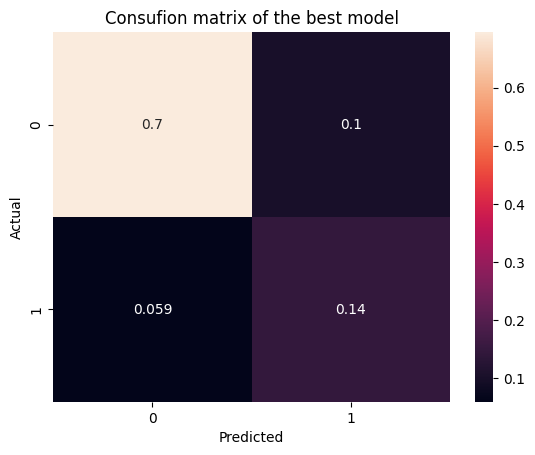

In [44]:
sns.heatmap(confusion_matrix(y_test_1, org_y_pred, normalize="all"), annot=True)
plt.title(f"Consufion matrix of the best model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

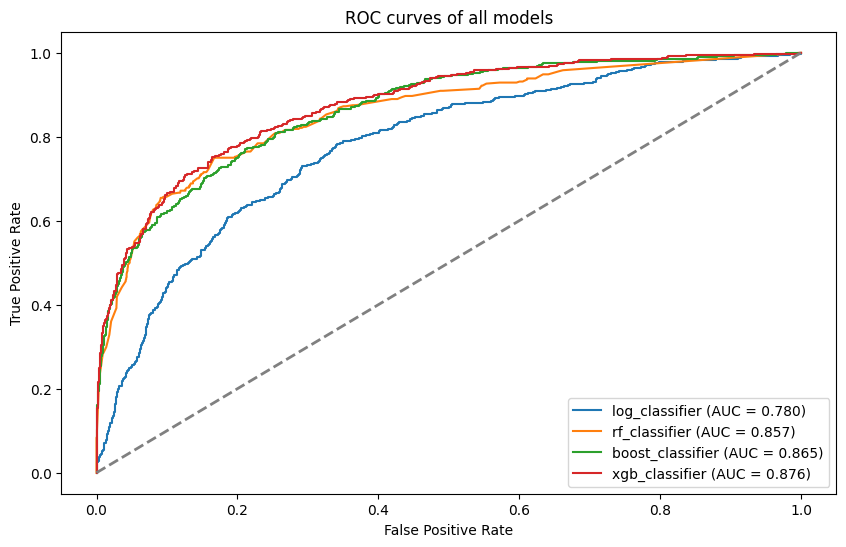

In [45]:
plot_roc_curves(new_pipes, X_train_1, y_train_1, X_test_1, y_test_1)

## New features


In [46]:
features_new = features_org.copy()
features_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SatisfactionScore,CardType,PointEarned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425


### Create new features

#### Binning

In [47]:
# Define the bin edges and labels
age_edges = [0, 18, 35, 60, float("inf")]
age_labels = ["Children", "Young Adult", "Adult", "Elder"]

cscore_edges = [0, 500, 600, 661, 781, 1000]
cscore_labels = ["Very Poor", "Poor", "Fair", "Good", "Excellent"]

tenure_edges = [0, 3, 6, float("inf")]
tenure_labels = ["Short", "Moderate", "Long"]

income_edges = [0, 30000, 50000, 70000, 100000, float("inf")]
income_labels = ["Low", "Lower-middle", "Middle", "Upper-middle", "High"]

# Create a new columns with the bin labels
features_new["AgeGroup"] = pd.cut(
    features_new["Age"], bins=age_edges, labels=age_labels, right=False
)
features_new["CreditScoreGroup"] = pd.cut(
    features_new["CreditScore"], bins=cscore_edges, labels=cscore_labels, right=False
)
features_new["TenureGroup"] = pd.cut(
    features_new["Tenure"], bins=tenure_edges, labels=tenure_labels, right=False
)
features_new["EstimatedSalaryGroup"] = pd.cut(
    features_new["EstimatedSalary"], bins=income_edges, labels=income_labels, right=False
)

# Display the updated dataframe
features_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SatisfactionScore,CardType,PointEarned,AgeGroup,CreditScoreGroup,TenureGroup,EstimatedSalaryGroup
0,619,France,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464,Adult,Fair,Short,High
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456,Adult,Fair,Short,High
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377,Adult,Poor,Long,High
3,699,France,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350,Adult,Good,Short,Upper-middle
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425,Adult,Excellent,Short,Upper-middle


#### Group by aggregation

In [48]:
grb_agg = (
    features_new.groupby(["Gender", "Age"])[["Balance", "EstimatedSalary", "CreditScore"]]
    .agg(["sum", "mean", "median","min", "max"])
)

# Flatten the MultiIndex
grb_agg.columns = ['_'.join(col).strip() for col in grb_agg.columns.values]

# Reset the index
grb_agg.reset_index(inplace=True)

features_new = features_new.merge(grb_agg, on=["Gender", "Age"], how='left')
features_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,EstimatedSalary_sum,EstimatedSalary_mean,EstimatedSalary_median,EstimatedSalary_min,EstimatedSalary_max,CreditScore_sum,CreditScore_mean,CreditScore_median,CreditScore_min,CreditScore_max
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,13785449.56,94420.887397,90547.855,823.36,199992.48,95252,652.410959,661.0,453,850
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,18088517.81,109627.380667,109783.290,236.45,199970.74,107841,653.581818,651.0,416,850
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,13785449.56,94420.887397,90547.855,823.36,199992.48,95252,652.410959,661.0,453,850
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,19732614.47,94868.338798,94049.540,555.28,199808.10,136040,654.038462,655.5,418,850
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,12754058.97,97359.228779,100236.020,548.52,199505.53,85630,653.664122,660.0,437,850


#### Ratio

In [49]:
features_new["Balance_to_Salary"] = (
    features_new["Balance"] / features_new["EstimatedSalary"]
)
features_new["Balance_to_CreditScore"] = (
    features_new["Balance"] / features_new["CreditScore"]
)
features_new["Salary_to_CreditScore"] = (
    features_new["EstimatedSalary"] / features_new["CreditScore"]
)
features_new["Balance_to_Age"] = features_new["Balance"] / features_new["Age"]
features_new["Salary_to_Age"] = features_new["EstimatedSalary"] / features_new["Age"]
features_new["CreditScore_to_Age"] = features_new["CreditScore"] / features_new["Age"]

features_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,CreditScore_mean,CreditScore_median,CreditScore_min,CreditScore_max,Balance_to_Salary,Balance_to_CreditScore,Salary_to_CreditScore,Balance_to_Age,Salary_to_Age,CreditScore_to_Age
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,652.410959,661.0,453,850,0.000000,0.000000,163.730016,0.000000,2413.068571,14.738095
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,653.581818,651.0,416,850,0.744677,137.841875,185.102928,2044.094146,2744.940976,14.829268
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,652.410959,661.0,453,850,1.401375,318.049402,226.955319,3801.447619,2712.656429,11.952381
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,654.038462,655.5,418,850,0.000000,0.000000,134.229800,0.000000,2405.811026,17.923077
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,653.664122,660.0,437,850,1.587055,147.659788,93.040118,2918.856279,1839.165116,19.767442


### Training

In [50]:
# Apply logarithmic transformation to the age column
features_new['Age_log'] = np.log(features_new['Age'])

# Display the updated dataframe
features_new.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,CreditScore_median,CreditScore_min,CreditScore_max,Balance_to_Salary,Balance_to_CreditScore,Salary_to_CreditScore,Balance_to_Age,Salary_to_Age,CreditScore_to_Age,Age_log
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,661.0,453,850,0.000000,0.000000,163.730016,0.000000,2413.068571,14.738095,3.737670
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,651.0,416,850,0.744677,137.841875,185.102928,2044.094146,2744.940976,14.829268,3.713572
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,661.0,453,850,1.401375,318.049402,226.955319,3801.447619,2712.656429,11.952381,3.737670
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,655.5,418,850,0.000000,0.000000,134.229800,0.000000,2405.811026,17.923077,3.663562
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,660.0,437,850,1.587055,147.659788,93.040118,2918.856279,1839.165116,19.767442,3.761200


In [51]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    features_new, target, test_size=0.2, shuffle=True, stratify=target, random_state=42
)

print(X_train_2.shape)
print(X_test_2.shape)

(8000, 39)
(2000, 39)


In [52]:
categorical_cols = [
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
    "EstimatedSalary",
    "SatisfactionScore",
]
binary_cols = ["Gender"]
ordinal_cols = ["CardType", "CreditScoreGroup", "TenureGroup", "EstimatedSalaryGroup"]
ohe_cols = ["Geography", "AgeGroup"]
numeric_cols = features_new.select_dtypes(include=[np.number]).columns.difference(
    categorical_cols
)

new_preprocessor = ColumnTransformer(
    transformers=[
        ("binary", OrdinalEncoder(), binary_cols),
        ("ordinal", OrdinalEncoder(), ordinal_cols),
        ("ohe", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        ("scaler", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)

In [53]:
X_train_2_test = new_preprocessor.fit_transform(X_train_2)

X_train_2_processed_df = pd.DataFrame(X_train_2_test, columns=new_preprocessor.get_feature_names_out())
X_train_2_processed_df.head()

,binary__Gender,ordinal__CardType,ordinal__CreditScoreGroup,ordinal__TenureGroup,ordinal__EstimatedSalaryGroup,ohe__Geography_France,ohe__Geography_Germany,ohe__Geography_Spain,ohe__AgeGroup_Adult,ohe__AgeGroup_Elder,...,scaler__EstimatedSalary_sum,scaler__PointEarned,scaler__Salary_to_Age,scaler__Salary_to_CreditScore,scaler__Tenure,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__SatisfactionScore
0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.297122,-0.814382,0.147423,-0.090490,-1.040992,2.0,1.0,0.0,104982.39,2.0
1,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.394449,0.003981,0.772131,0.039065,-1.386980,1.0,1.0,1.0,119327.75,1.0
2,1.0,3.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-1.891134,0.105723,0.096704,0.885441,-1.040992,1.0,0.0,1.0,186172.85,1.0
3,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.070467,-1.154997,-1.233913,-1.396194,-0.349016,1.0,1.0,0.0,15470.91,1.0
4,0.0,3.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,...,-1.507137,0.114570,-0.594607,-0.160381,1.034937,2.0,0.0,1.0,95463.29,3.0


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4278
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


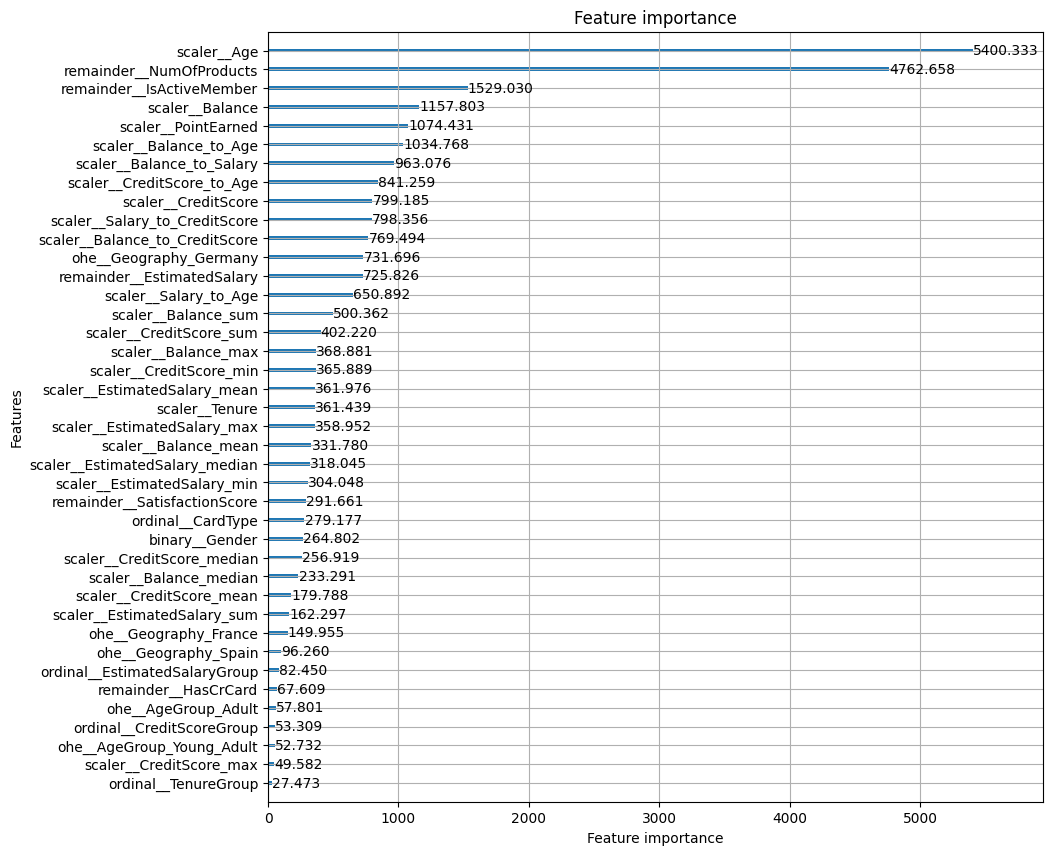

In [54]:
# Define the LightGBM model
model = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train_2_processed_df, y_train_2)

# Plot feature importances
lgb.plot_importance(model, importance_type='gain', figsize=(10, 10))
plt.show()

In [55]:
# Create the combined pipelines
new_comb_log = imbPipeline(
    steps=[
        ("preprocessor", new_preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("log_classifier", LogisticRegression(random_state=42)),
    ]
)

new_comb_rf = imbPipeline(
    steps=[
        ("preprocessor", new_preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("rf_classifier", RandomForestClassifier(random_state=42)),
    ]
)

new_comb_gdb = imbPipeline(
    steps=[
        ("preprocessor", new_preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("boost_classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

new_comb_xgb = imbPipeline(
    steps=[
        ("preprocessor", new_preprocessor),
        ("sampler", over_sampling),
        ("undersampler", under_sampling),
        ("xgb_classifier", XGBClassifier()),
    ]
)

In [56]:
# Build the new pipelines
new_pipes = [
    imbPipeline(
        steps=[
            ("preprocessor", new_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("log_classifier", LogisticRegression(**list_params_dict[0])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("rf_classifier", RandomForestClassifier(**list_params_dict[1])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("boost_classifier", GradientBoostingClassifier(**list_params_dict[2])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("xgb_classifier", XGBClassifier(**list_params_dict[3])),
        ]
    ),
]

# Create a DataFrame to store the results
results_df_7 = pd.DataFrame(
    columns=[
        "Undersampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each pipeline
for pipe in new_pipes:
    # Get the model name
    model_name = pipe.steps[-1][0]

    # Evaluate the pipeline using cross-validation
    scores = cross_validate(pipe, X_train_2, y_train_2, cv=kfold, scoring=scoring)

    results_df_7 = pd.concat(
        [
            results_df_7,
            pd.DataFrame(
                {
                    "Undersampling Technique": "RandomUnderSampler + SMOTE",
                    "Model": [model_name],
                    "Mean ROC AUC": np.mean(scores["test_roc_auc"]),
                    "Accuracy": np.mean(scores["test_accuracy"]),
                    "Precision": np.mean(scores["test_precision"]),
                    "Recall": np.mean(scores["test_recall"]),
                    "F1 Score": np.mean(scores["test_f1"]),
                }
            ),
        ],
        ignore_index=True,
    )

results_df_7

,Undersampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,RandomUnderSampler + SMOTE,log_classifier,0.786274,0.724250,0.399303,0.699387,0.508240
1,RandomUnderSampler + SMOTE,rf_classifier,0.824099,0.846875,0.665712,0.500613,0.571065
2,RandomUnderSampler + SMOTE,boost_classifier,0.848565,0.852000,0.686110,0.504294,0.581285
3,RandomUnderSampler + SMOTE,xgb_classifier,0.857353,0.843500,0.620620,0.598773,0.609411


In [57]:
new_comb_logistic_cv = cross_validate(
    new_comb_log, X_train_2, y_train_2, cv=kfold, scoring=scoring
)
new_comb_rf_cv = cross_validate(new_comb_rf, X_train_2, y_train_2, cv=kfold, scoring=scoring)
new_comb_grb_cv = cross_validate(new_comb_gdb, X_train_2, y_train_2, cv=kfold, scoring=scoring)
new_comb_xgb_cv = cross_validate(new_comb_xgb, X_train_2, y_train_2, cv=kfold, scoring=scoring)

new_comb_resampled_cv_scores = [new_comb_logistic_cv, new_comb_rf_cv, new_comb_grb_cv, new_comb_xgb_cv]

result_df_7 = pd.DataFrame(
    {
        "Model name": names,
        "Accuracy": [
            np.mean(scores["test_accuracy"]) for scores in new_comb_resampled_cv_scores
        ],
        "Precision": [
            np.mean(scores["test_precision"]) for scores in new_comb_resampled_cv_scores
        ],
        "Recall": [
            np.mean(scores["test_recall"]) for scores in new_comb_resampled_cv_scores
        ],
        "ROC AUC": [
            np.mean(scores["test_roc_auc"]) for scores in new_comb_resampled_cv_scores
        ],
        "F1 Score": [np.mean(scores["test_f1"]) for scores in new_comb_resampled_cv_scores],
    }
)

result_df_7.set_index("Model name", inplace=True)
result_df_7

,Accuracy,Precision,Recall,ROC AUC,F1 Score
Model name,,,,,
Logistic Regression,0.71850,0.391944,0.689571,0.772682,0.499709
Random Forest,0.85050,0.693897,0.476687,0.830018,0.564883
Gradient Boosting,0.85850,0.718797,0.501840,0.857761,0.590862
XGBoost,0.84975,0.685072,0.488344,0.833114,0.570002


In [58]:
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_2_processed_df.columns, 'Importance': feature_importances}).sort_values('Importance')
importance_df

,Feature,Importance
17,scaler__Balance_min,0
12,scaler__Age_log,0
9,ohe__AgeGroup_Elder,0
10,ohe__AgeGroup_Young Adult,3
3,ordinal__TenureGroup,4
8,ohe__AgeGroup_Adult,9
23,scaler__CreditScore_max,10
2,ordinal__CreditScoreGroup,14
39,remainder__HasCrCard,15
7,ohe__Geography_Spain,18


In [59]:
no_selected_feats = [
    "Age_log",
    "AgeGroup",
    "CreditScoreGroup",
    "TenureGroup",
    "EstimatedSalaryGroup",
    "CreditScore_max",
    "CreditScore_sum",
    "HasCrCard",
    "EstimatedSalary_sum",
    "Gender",
    "Geography",
]

X_train_3 = X_train_2.drop(no_selected_feats, axis=1)
X_train_3.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary', 'SatisfactionScore', 'CardType',
       'PointEarned', 'Balance_sum', 'Balance_mean', 'Balance_median',
       'Balance_min', 'Balance_max', 'EstimatedSalary_mean',
       'EstimatedSalary_median', 'EstimatedSalary_min', 'EstimatedSalary_max',
       'CreditScore_mean', 'CreditScore_median', 'CreditScore_min',
       'Balance_to_Salary', 'Balance_to_CreditScore', 'Salary_to_CreditScore',
       'Balance_to_Age', 'Salary_to_Age', 'CreditScore_to_Age'],
      dtype='object')

In [60]:
categorical_cols = [
    "NumOfProducts",
    "IsActiveMember",
    "EstimatedSalary",
    "SatisfactionScore",
]
ordinal_cols = ["CardType"]
numeric_cols = X_train_3.select_dtypes(include=[np.number]).columns.difference(
    categorical_cols
)

new_selected_preprocessor = ColumnTransformer(
    transformers=[
        #("binary", OrdinalEncoder(), binary_cols),
        ("ordinal", OrdinalEncoder(), ordinal_cols),
        #("ohe", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        ("scaler", StandardScaler(), numeric_cols),
    ],
    remainder="passthrough",
)

Index(['Age', 'Balance', 'Balance_max', 'Balance_mean', 'Balance_median',
       'Balance_min', 'Balance_sum', 'Balance_to_Age',
       'Balance_to_CreditScore', 'Balance_to_Salary', 'CreditScore',
       'CreditScore_mean', 'CreditScore_median', 'CreditScore_min',
       'CreditScore_to_Age', 'EstimatedSalary_max', 'EstimatedSalary_mean',
       'EstimatedSalary_median', 'EstimatedSalary_min', 'PointEarned',
       'Salary_to_Age', 'Salary_to_CreditScore', 'Tenure'],
      dtype='object')


'\nX_train_3_test = new_selected_preprocessor.fit_transform(X_train_3)\nX_train_3_processed_df = pd.DataFrame(X_train_3_test, columns=new_selected_preprocessor.get_feature_names_out())\nX_train_3_processed_df.head()\n'

In [61]:
# Build the new pipelines
new_pipes = [
    imbPipeline(
        steps=[
            ("preprocessor", new_selected_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("log_classifier", LogisticRegression(**list_params_dict[0])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_selected_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("rf_classifier", RandomForestClassifier(**list_params_dict[1])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_selected_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("boost_classifier", GradientBoostingClassifier(**list_params_dict[2])),
        ]
    ),
    imbPipeline(
        steps=[
            ("preprocessor", new_selected_preprocessor),
            ("sampler", over_sampling),
            ("undersampler", under_sampling),
            ("xgb_classifier", XGBClassifier(**list_params_dict[3])),
        ]
    ),
]

# Create a DataFrame to store the results
results_df_8 = pd.DataFrame(
    columns=[
        "Undersampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each pipeline
for pipe in new_pipes:
    # Get the model name
    model_name = pipe.steps[-1][0]

    # Evaluate the pipeline using cross-validation
    scores = cross_validate(pipe, X_train_3, y_train_2, cv=kfold, scoring=scoring)

    results_df_8 = pd.concat(
        [
            results_df_8,
            pd.DataFrame(
                {
                    "Undersampling Technique": "RandomUnderSampler + SMOTE",
                    "Model": [model_name],
                    "Mean ROC AUC": np.mean(scores["test_roc_auc"]),
                    "Accuracy": np.mean(scores["test_accuracy"]),
                    "Precision": np.mean(scores["test_precision"]),
                    "Recall": np.mean(scores["test_recall"]),
                    "F1 Score": np.mean(scores["test_f1"]),
                }
            ),
        ],
        ignore_index=True,
    )

results_df_8

,Undersampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,RandomUnderSampler + SMOTE,log_classifier,0.766930,0.726125,0.397183,0.661350,0.496160
1,RandomUnderSampler + SMOTE,rf_classifier,0.828622,0.837375,0.606486,0.575460,0.590311
2,RandomUnderSampler + SMOTE,boost_classifier,0.828389,0.842750,0.645889,0.506748,0.567666
3,RandomUnderSampler + SMOTE,xgb_classifier,0.838677,0.828625,0.576986,0.596319,0.586468
